# Highway Scene Segmentation

This notebook showcases semantic scene segmentation into background pixels and a foreground with driving cars. Both training and validation data are taken from the highway scene in the Change Detection dataset, which consists of labeled highway camera frames (except the first 470 which are unlabeled): http://jacarini.dinf.usherbrooke.ca/dataset2014#

Input: 
  - RGB 
  - Shape $(3,240,320)$

Label:
  - Greyscale
  - 0:black:background, 170:grey:foreground-edges,  255:white:foreground
  - Shape $(1,240,320)$


![input image](showcase/in001600.jpg "Title") ![gt image](showcase/gt001600.png "Title")

## Imports

In [1]:
import os
from torch.utils.data import Dataset, random_split
from torchvision.io import read_image
from torchvision.transforms import v2
from torchvision import tv_tensors

import torch
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score
import numpy as np
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Pytorch Dataset Wrapper
Inherits from **torch.utils.data.Dataset** and implements:
- **def \_\_getitem\_\_(self, idx)**: given an integer idx returns the data (img, mask)
    - img is the image as a float tensor of shape: $(3,H,W)$
    - mask is the label image as a segmentation mask of shape: $(1,H,W)$; each pixel should contain the label 0 (background) or 1 (foreground).

In [2]:
class HighwayDataset(Dataset):
    def __init__(self, device, split=None, train_ratio=0.8, augmentation=None):
        self.input_filenames = sorted(os.listdir("highway/input"))[470:]
        self.labels_filenames = sorted(os.listdir("highway/groundtruth"))[470:]

        self.split = split

        dataset_len = len(self.input_filenames)
        if split == "train":
            self.input_filenames = self.input_filenames[:int(dataset_len*train_ratio)]
            self.labels_filenames = self.labels_filenames[:int(dataset_len*train_ratio)]
        elif split == "val":
            self.input_filenames = self.input_filenames[int(dataset_len*train_ratio):]
            self.labels_filenames = self.labels_filenames[int(dataset_len*train_ratio):]
        else:
            raise ValueError("split must be 'train' or 'val'")

        self.augmentation = augmentation
        self.device = device

        self.inputs = []
        self.labels = []

        for i in range(len(self.input_filenames)):
            image = read_image( "highway/input/" + self.input_filenames[i]).float()/255
            label = (read_image( "highway/groundtruth/" + self.labels_filenames[i]) > 0).float()

            self.inputs.append(image)
            self.labels.append(label)

        self.inputs = torch.stack(self.inputs).to(device)
        self.labels = torch.stack(self.labels).to(device)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        if self.split == "train":
            img, mask = self.augmentation(
                self.inputs[idx],
                tv_tensors.Mask(self.labels[idx])
                )
        else:
            img = self.inputs[idx]
            mask = self.labels[idx]

        return img, mask

## Fully-Convolutional Neural Network
The CNN inspired by U-Net is flexible to the input and output resolution and has skip connections in parallel to the bottleneck.

- input: a batch of images $(B,3,H,W)$
- output: a batch of pixel-wise class predictions $(B,1,H,W)$

In [3]:
class SmallUNet(nn.Module):
    def __init__(self):
        super(SmallUNet, self).__init__()

        self.sideconv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.sideconv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.sideconv3 = nn.Conv2d(128, 256, 3, 1, 1)
        self.sideconv4 = nn.Conv2d(256, 256, 3, 1, 1)
        self.upconv1 = nn.ConvTranspose2d(256, 256, 2, 2)
        self.sideconv5 = nn.Conv2d(512, 128, 3, 1, 1)
        self.upconv2 = nn.ConvTranspose2d(128, 128, 2, 2)
        self.sideconv6 = nn.Conv2d(256, 64, 3, 1, 1)
        self.upconv3 = nn.ConvTranspose2d(64, 64, 2, 2)
        self.sideconv7 = nn.Conv2d(128, 1, 3, 1, 1)

    def forward(self, x):
        
        # Encoder
        x = self.sideconv1(x)
        x_res1 = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.sideconv2(x)
        x_res2 = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.sideconv3(x)
        x_res3 = F.relu(x)
        x = F.max_pool2d(x, 2)

        # Bottleneck
        x = self.sideconv4(x)
        x = F.relu(x)

        # Decoder
        x = self.upconv1(x)
        x = F.relu(x)
        x = torch.cat((x, x_res3), dim=1)
        x = self.sideconv5(x)
        x = F.relu(x)

        x = self.upconv2(x)
        x = F.relu(x)
        x = torch.cat((x, x_res2), dim=1)
        x = self.sideconv6(x)
        x = F.relu(x)

        x = self.upconv3(x)
        x = F.relu(x)
        x = torch.cat((x, x_res1), dim=1)
        output = self.sideconv7(x)

        return output

## Train and Validation Function

In [4]:
def train_segmenter(model,  train_loader, criterion, optimizer, epoch, loss_list):
    model.train()

    epoch_loss = 0

    for batch_idx, (input, label) in enumerate(train_loader):
        optimizer.zero_grad()

        output = model(input)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, (batch_idx+1) * len(input), len(train_loader.dataset),
            100. * (batch_idx+1) / len(train_loader), loss.item()), end='\r')


    loss_list.append(epoch_loss / len(train_loader))


def val_segmenter(model,  val_loader, criterion, loss_list):
    model.eval()
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (input, label) in enumerate(val_loader):
            output = model(input)
            val_loss += criterion(output, label).item()
            pred = (output > 0.5).float()
            correct += (pred==label).sum().item()



    val_loss /= len(val_loader)

    print('Val set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    val_loss, correct, len(val_loader.dataset)*320*240,
    (100. * correct) / (len(val_loader.dataset)*320*240) , end='\r')) 

    loss_list.append(val_loss)

## Augmentation and Data instantiation
- 90/10 split

In [5]:
augmentations = v2.Compose([
    v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0),
    v2.RandomResizedCrop(size=(160,120)),
    v2.RandomRotation(20),
    v2.RandomHorizontalFlip(p=0.5),
    #v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
train_dataset = HighwayDataset(device, split="train", train_ratio=0.9, augmentation=augmentations)
val_dataset = HighwayDataset(device, split="val", train_ratio=0.9)

## Training Loop
- PyTorch DataLoaders
- BCE Criterion
- Adam Optimizer

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=48, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

model = SmallUNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

train_losses = []
val_losses = []

epochs = 15

for epoch in range(1,epochs + 1):
    train_segmenter(model, train_loader, criterion, optimizer, epoch, train_losses)
    val_segmenter(model,  val_loader, criterion, val_losses)
    scheduler.step()

Val set: Average loss: 0.3650, Accuracy: 8239503/9446400 (87%)

Val set: Average loss: 0.3639, Accuracy: 8239503/9446400 (87%)

Val set: Average loss: 0.2274, Accuracy: 8239503/9446400 (87%)

Val set: Average loss: 0.1170, Accuracy: 8770434/9446400 (93%)

Val set: Average loss: 0.0928, Accuracy: 9151574/9446400 (97%)

Val set: Average loss: 0.0688, Accuracy: 9242790/9446400 (98%)

Val set: Average loss: 0.0500, Accuracy: 9289932/9446400 (98%)

Val set: Average loss: 0.0643, Accuracy: 9179850/9446400 (97%)

Val set: Average loss: 0.0564, Accuracy: 9272554/9446400 (98%)

Val set: Average loss: 0.0373, Accuracy: 9297674/9446400 (98%)

Val set: Average loss: 0.0355, Accuracy: 9307609/9446400 (99%)

Val set: Average loss: 0.0345, Accuracy: 9312613/9446400 (99%)

Val set: Average loss: 0.0339, Accuracy: 9314541/9446400 (99%)

Val set: Average loss: 0.0335, Accuracy: 9319190/9446400 (99%)

Val set: Average loss: 0.0326, Accuracy: 9320478/9446400 (99%)



In [ ]:
# torch.save(model.state_dict(), 'final_params.pth')

In [9]:
model = SmallUNet().to(device)
model.load_state_dict(torch.load('final_params.pth', map_location=device))

<All keys matched successfully>

In [10]:
def get_segmentation(model, device, test_loader):
    model.eval()
    segmentations = []
    accuracies = []
    precisions = []
    recalls = []
    ious = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            segmentations.append(pred.detach().cpu().numpy())

            for i in range(data.size(0)):  
                pred_flat = pred[i].cpu().numpy().flatten()
                target_flat = target[i].cpu().numpy().flatten()

                accuracies.append(accuracy_score(target_flat, pred_flat))
                precisions.append(precision_score(target_flat, pred_flat, average='macro', zero_division=0))
                recalls.append(recall_score(target_flat, pred_flat, average='macro'))
                ious.append(jaccard_score(target_flat, pred_flat, average='macro'))

    #print(accuracies, precisions, recalls, ious)
    return np.concatenate(segmentations), np.array(accuracies), np.array(precisions), np.array(recalls), np.array(ious)

## Report TODO: Rework
- Pixel-wise: Accuracy, Precision, Recall
- Image-wise: Intersection over Union

In [11]:
results, acc, prec, rec, iou = get_segmentation(model, device, val_loader)

In [12]:
results.shape, acc.shape, prec.shape, rec.shape, iou.shape

((123, 240, 320), (123,), (123,), (123,), (123,))

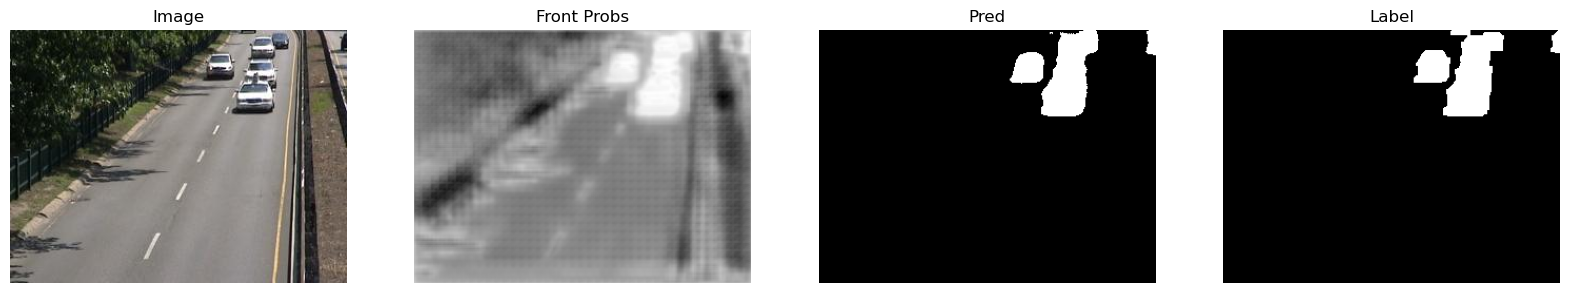

In [13]:
model.eval()  # Set the model to evaluation mode

# Get a single batch from the dataloader
data, target = next(iter(val_loader))

sample_number = 1

# Make sure data is on the correct device (e.g., CPU or GPU)
input_sample = data[sample_number].detach().cpu()  # Assuming you're using CUDA, otherwise remove this line
label_sample = target[sample_number].detach().cpu().squeeze()

# Perform inference with no gradient computation
with torch.no_grad():
    probs_sample = model(data[sample_number:sample_number+1]).detach().cpu().squeeze()
    preds_sample = torch.sigmoid(probs_sample) > 0.5

plt.figure(figsize=(20,20))

plt.subplot(1, 4, 1)
plt.imshow(input_sample.permute(1, 2, 0))
plt.axis("off")
plt.title("Image")

plt.subplot(1, 4, 2)
plt.imshow(probs_sample.detach().cpu(), cmap="gray")
plt.axis("off")
plt.title("Front Probs")

plt.subplot(1, 4, 3)
plt.imshow(preds_sample, cmap="gray")
plt.axis("off")
plt.title("Pred")

plt.subplot(1, 4, 4)
plt.imshow(label_sample, cmap="gray")
plt.axis("off")
plt.title("Label")

plt.show()

# Training and Test Error over each Epoch


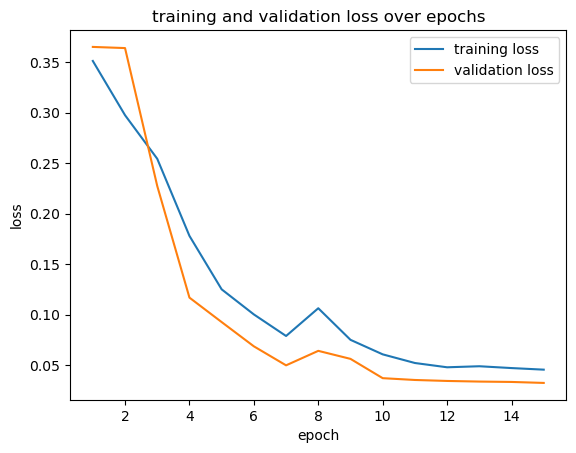

In [14]:
x = [ i+1 for i in range(epochs)]


plt.plot(x, train_losses, label='training loss')
plt.plot(x, val_losses, label='validation loss')

plt.title('training and validation loss over epochs')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()

plt.show()

## Evaluation Metrics for Final Model

In [15]:
#print(highwayDataset.gts[test_dataset.indices].shape)
#print(classification_report(highwayDataset.gts[test_dataset.indices].detach().cpu().flatten(), results.flatten()))

[0.94951823 0.9478776  0.94710938 0.94582031 0.94585937 0.94492188
 0.94364583 0.94325521 0.94246094 0.94147135 0.94061198 0.9394401
 0.93807292 0.93764323 0.93601563 0.93440104 0.93309896 0.93253906
 0.93214844 0.93144531 0.92994792 0.92885417 0.9274349  0.92604167
 0.9244401  0.92394531 0.92144531 0.92158854 0.91907552 0.91778646
 0.91580729 0.91489583 0.91384115 0.91151042 0.90970052 0.908125
 0.90571615 0.90425781 0.90177083 0.89950521 0.89815104 0.89519531
 0.89360677 0.89111979 0.88821615 0.88596354 0.88257812 0.88005208
 0.87727865 0.87496094 0.871875   0.86773437 0.86490885 0.86115885
 0.85865885 0.85540365 0.85058594 0.8465625  0.84391927 0.8400651
 0.83529948 0.83079427 0.82588542 0.82125    0.81641927 0.8136849
 0.81542969 0.81661458 0.81591146 0.81856771 0.82098958 0.82236979
 0.82346354 0.82377604 0.82657552 0.82903646 0.83356771 0.83729167
 0.83983073 0.84363281 0.84571615 0.84765625 0.84584635 0.84346354
 0.84160156 0.83696615 0.83263021 0.82809896 0.82424479 0.82019531


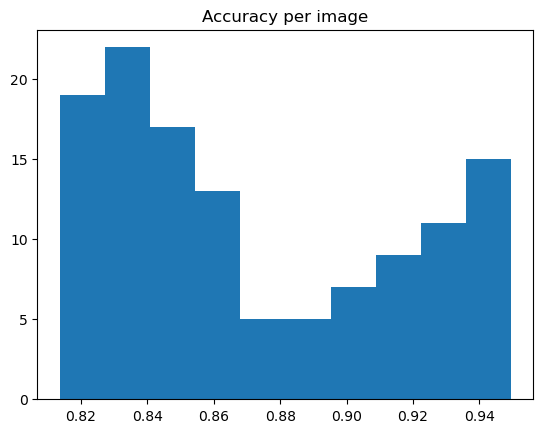

In [16]:
print(acc)
plt.hist(acc)
plt.title("Accuracy per image")
plt.show()

[0.47475911 0.4739388  0.47355469 0.47291016 0.47292969 0.47246094
 0.47182292 0.4716276  0.47123047 0.47073568 0.47030599 0.46972005
 0.46903646 0.46882161 0.46800781 0.46720052 0.46654948 0.46626953
 0.46607422 0.46572266 0.46497396 0.46442708 0.46371745 0.46302083
 0.46222005 0.46197266 0.46072266 0.46079427 0.45953776 0.45889323
 0.45790365 0.45744792 0.45692057 0.45575521 0.45485026 0.4540625
 0.45285807 0.45212891 0.45088542 0.4497526  0.44907552 0.44759766
 0.44680339 0.4455599  0.44410807 0.44298177 0.44128906 0.44002604
 0.43863932 0.43748047 0.4359375  0.43386719 0.43245443 0.43057943
 0.42932943 0.42770182 0.42529297 0.42328125 0.42195964 0.42003255
 0.41764974 0.41539714 0.41294271 0.410625   0.40820964 0.40684245
 0.40771484 0.40830729 0.40795573 0.40928385 0.41049479 0.4111849
 0.41173177 0.41188802 0.41328776 0.41451823 0.41678385 0.41864583
 0.41991536 0.42181641 0.42285807 0.42382812 0.42292318 0.42173177
 0.42080078 0.41848307 0.4163151  0.41404948 0.4121224  0.410097

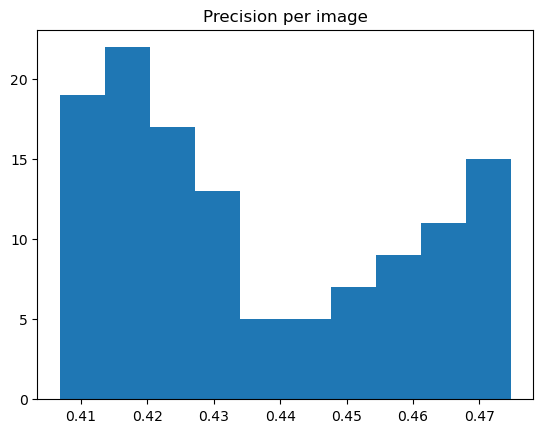

In [17]:
print(prec)
plt.hist(prec)
plt.title("Precision per image")
plt.show()

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


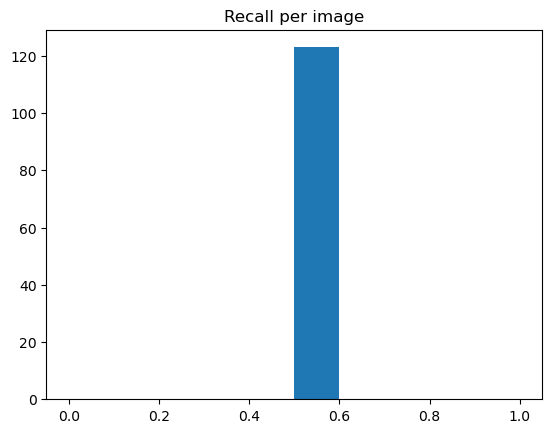

In [18]:
print(rec)
plt.hist(rec)
plt.title("Recall per image")
plt.show()

[0.47475911 0.4739388  0.47355469 0.47291016 0.47292969 0.47246094
 0.47182292 0.4716276  0.47123047 0.47073568 0.47030599 0.46972005
 0.46903646 0.46882161 0.46800781 0.46720052 0.46654948 0.46626953
 0.46607422 0.46572266 0.46497396 0.46442708 0.46371745 0.46302083
 0.46222005 0.46197266 0.46072266 0.46079427 0.45953776 0.45889323
 0.45790365 0.45744792 0.45692057 0.45575521 0.45485026 0.4540625
 0.45285807 0.45212891 0.45088542 0.4497526  0.44907552 0.44759766
 0.44680339 0.4455599  0.44410807 0.44298177 0.44128906 0.44002604
 0.43863932 0.43748047 0.4359375  0.43386719 0.43245443 0.43057943
 0.42932943 0.42770182 0.42529297 0.42328125 0.42195964 0.42003255
 0.41764974 0.41539714 0.41294271 0.410625   0.40820964 0.40684245
 0.40771484 0.40830729 0.40795573 0.40928385 0.41049479 0.4111849
 0.41173177 0.41188802 0.41328776 0.41451823 0.41678385 0.41864583
 0.41991536 0.42181641 0.42285807 0.42382812 0.42292318 0.42173177
 0.42080078 0.41848307 0.4163151  0.41404948 0.4121224  0.410097

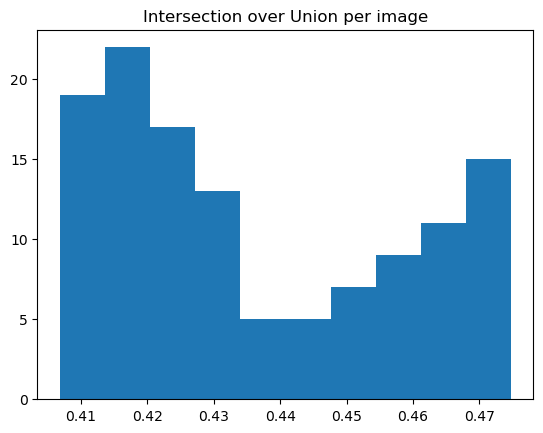

In [19]:
print(iou)
plt.hist(iou)
plt.title("Intersection over Union per image")
plt.show()